# QR Code Authentication: Detecting Original vs. Counterfeit Prints

### 1. Setup and Data Loading - We install necessary libraries and load the dataset.

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn opencv-python tensorflow keras torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [6]:
# importing libraries
import cv2
import numpy as np
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import os
import matplotlib.pyplot as plt

### Loading the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data_dir = "/content/drive/My Drive/new/alemeno"
dataset_path = "/content/drive/My Drive/new/alemeno"
first_print_path = os.path.join(dataset_path, "First Print")
second_print_path = os.path.join(dataset_path, "Second Print")

In [9]:
def load_images(root_dir):
    image_paths = []
    labels = []

    for label, category in enumerate(["First Print", "Second Print"]):
        category_path = os.path.join(root_dir, category)
        if os.path.exists(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                image_paths.append(img_path)
                labels.append(label)

    return image_paths, labels

In [10]:
image_paths, labels = load_images(dataset_path)

print(f"Total images: {len(image_paths)}")
print(f"First Print images: {labels.count(0)}")
print(f"Second Print images: {labels.count(1)}")

Total images: 203
First Print images: 103
Second Print images: 100


### Displaying Sample images from the dataset

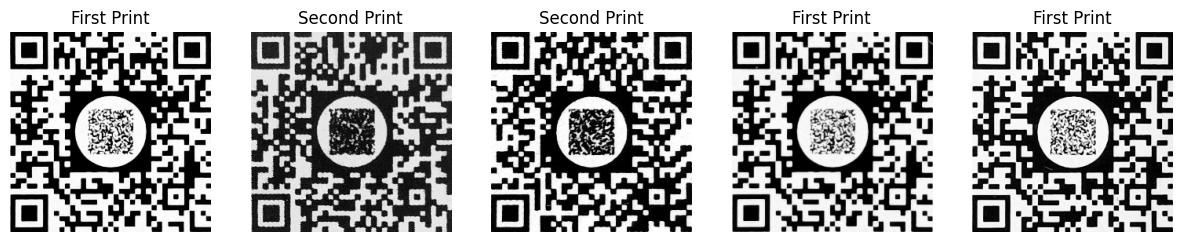

In [11]:
# Display sample images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, idx in enumerate(np.random.choice(len(image_paths), 5, replace=False)):
    img = cv2.imread(image_paths[idx], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))  # Ensure all images have the same size
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title("First Print" if labels[idx] == 0 else "Second Print")
    axes[i].axis("off")

plt.show()

In [12]:
# Load images and extract ORB features
def extract_orb_features(image_paths):
    orb = cv2.ORB_create(nfeatures=500)
    feature_list = []
    labels = []

    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))  # Resize for consistency

        # ORB feature extraction
        keypoints, descriptors = orb.detectAndCompute(img, None)
        if descriptors is not None:
            feature_list.append(descriptors.flatten())  # Flatten to 1D array
        else:
            feature_list.append(np.zeros(500))  # Placeholder if no keypoints found

        labels.append(0 if "First Print" in img_path else 1)  # Assign labels

    return np.array(feature_list, dtype=object), np.array(labels)

In [13]:
# Extract features
X, y = extract_orb_features(image_paths)

# Convert to same length using padding
max_length = max(len(f) for f in X)
X = np.array([np.pad(f, (0, max_length - len(f)), 'constant') for f in X])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Now Train SVM Model

In [14]:
# Train an SVM classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test)

# Evaluation
print("SVM Model Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

SVM Model Accuracy: 0.9024390243902439

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        22
           1       0.83      1.00      0.90        19

    accuracy                           0.90        41
   macro avg       0.91      0.91      0.90        41
weighted avg       0.92      0.90      0.90        41



### So SVM Model Accuracy is 90.24%

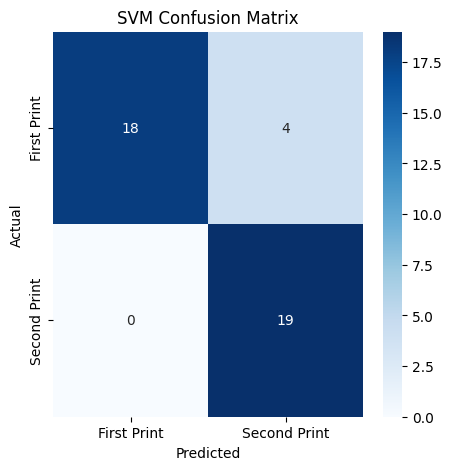

In [15]:
# Confusion Matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d", cmap="Blues", xticklabels=["First Print", "Second Print"], yticklabels=["First Print", "Second Print"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()

## CNN

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [17]:
# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [18]:
# Define dataset path
dataset_path = "/content/drive/My Drive/new/alemeno"

# Load datasets
train_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# Define CNN model
class QRCodeCNN(nn.Module):
    def __init__(self):
        super(QRCodeCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjusted for 64x64 images
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
# Initialize model, loss, and optimizer
model = QRCodeCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = (correct / total) * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch 1/10, Loss: 1.0516, Accuracy: 45.81%
Epoch 2/10, Loss: 0.6649, Accuracy: 51.23%
Epoch 3/10, Loss: 0.5822, Accuracy: 59.11%
Epoch 4/10, Loss: 0.4954, Accuracy: 72.91%
Epoch 5/10, Loss: 0.4039, Accuracy: 79.80%
Epoch 6/10, Loss: 0.3687, Accuracy: 79.31%
Epoch 7/10, Loss: 0.3330, Accuracy: 81.28%
Epoch 8/10, Loss: 0.2717, Accuracy: 86.21%
Epoch 9/10, Loss: 0.2853, Accuracy: 87.19%
Epoch 10/10, Loss: 0.2264, Accuracy: 90.15%


In [22]:
# Save model
torch.save(model.state_dict(), "cnn_model.pth")
print("✅ Model trained and saved successfully!")

✅ Model trained and saved successfully!


In [23]:
# Evaluate the model
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [24]:
# Print classification report
print("\n📌 CNN Model Performance:")
print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"✅ Precision: {precision_score(y_true, y_pred):.4f}")
print(f"✅ Recall: {recall_score(y_true, y_pred):.4f}")
print(f"✅ F1-score: {f1_score(y_true, y_pred):.4f}")
print("\n📊 Classification Report:\n", classification_report(y_true, y_pred))


📌 CNN Model Performance:
✅ Accuracy: 0.9409
✅ Precision: 1.0000
✅ Recall: 0.8800
✅ F1-score: 0.9362

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.94       103
           1       1.00      0.88      0.94       100

    accuracy                           0.94       203
   macro avg       0.95      0.94      0.94       203
weighted avg       0.95      0.94      0.94       203



## So, Accuracy of CNN is 94.09%

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [26]:
# CNN Metrics
cnn_accuracy = accuracy_score(y_true, y_pred)
cnn_precision = precision_score(y_true, y_pred)
cnn_recall = recall_score(y_true, y_pred)
cnn_f1 = f1_score(y_true, y_pred)

# SVM Metrics
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)


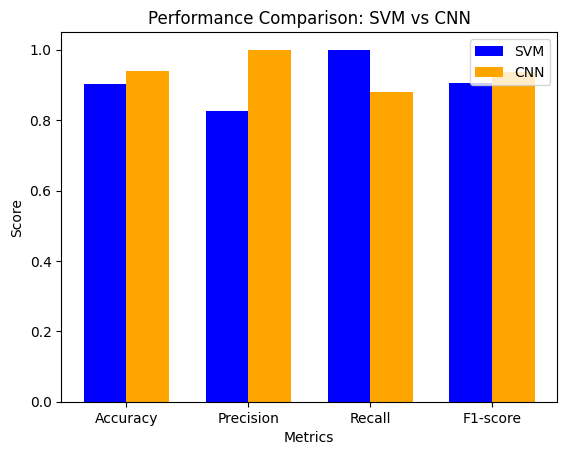

In [27]:
# Organizing data
labels = ["Accuracy", "Precision", "Recall", "F1-score"]
svm_values = [svm_accuracy, svm_precision, svm_recall, svm_f1]
cnn_values = [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1]

x = np.arange(len(labels))  # X-axis positions
width = 0.35  # Bar width

# Plotting
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, svm_values, width, label="SVM", color='blue')
bars2 = ax.bar(x + width/2, cnn_values, width, label="CNN", color='orange')

# Labels and formatting
ax.set_xlabel("Metrics")
ax.set_ylabel("Score")
ax.set_title("Performance Comparison: SVM vs CNN")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show plot
plt.show()